In [1]:
# Importing all usefull libraries
import numpy as np
import gravmag as gmc
import datafiltering as df
from auxiliars import addnoise
import matplotlib.pyplot as plt

In [2]:
def cc(data1, data2):
    '''
    Description
    '''
    
    m1, m2 = data1.mean(), data2.mean()
    
    dim1, dim2 = data1.ndim, data2.ndim
    
    #if dim1 == 2:
    #    data1 = data1.reshape(data1.size)
    #if dim2 == 2:
    #    data2 = data2.reshape(data2.size)
    
    # Formulation
    num = np.sum((data1 - m1)*(data2 - m2))
    s1 = np.sum((data1 - m1)**2)
    s2 = np.sum((data2 - m2)**2)
    cc = num/np.sqrt(s1*s2)    
    return cc

In [53]:
x = np.linspace(-1000, 1000, 50)
y = np.copy(x)
z = -10.
modelgrav = (0., 0., 100., 120., 2300.)
modelmag = (0., 0., 100., 120., 2.3)

In [74]:
gz = gmc.sphere_gz(x, y, z, modelgrav)
tf = gmc.sphere_tfa(x, y, z, modelmag, (45., 0.), (45., 0))

In [75]:
print gz.min(), gz.max(), gz.mean()
print tf.min(), tf.max(), tf.mean()
print gz.size, gz.shape
print tf.size, tf.shape

0.00428153651141 8.30856017143 0.697778480903
-496.341440601 1100.70545585 23.88710766
50 (50L,)
50 (50L,)


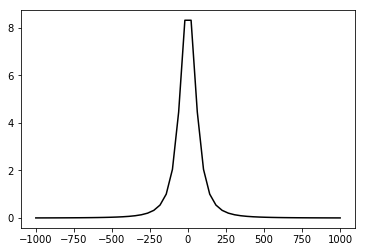

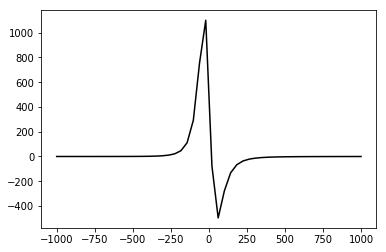

In [76]:
plt.figure()
plt.plot(x, gz, 'k-')
plt.show()
plt.figure()
plt.plot(x, tf, 'k-')
plt.show()

In [77]:
cc1 = np.corrcoef(gz, tf)
cc2 = np.correlate(gz, tf, mode = 'valid')
cc3 = np.correlate(gz, tf, mode = 'same')
cc4 = np.correlate(gz, tf, mode = 'full')
mycc = cc(gz, tf)

In [78]:
print cc1.size, cc2.size, cc3.size, cc4.size, mycc.size
print cc1.shape, cc2.shape, cc3.shape, cc4.shape, mycc.shape

4 1 50 99 1
(2L, 2L) (1L,) (50L,) (99L,) ()


In [79]:
print cc1
print cc2
print mycc
print cc3.min(), cc3.max(), cc3.mean()
print cc4.min(), cc4.max(), cc4.mean()

[[ 1.          0.46157255]
 [ 0.46157255  1.        ]]
[ 9635.3313669]
0.461572554628
-4543.03481305 15261.1348759 833.394873973
-4543.03481305 15261.1348759 420.906810509


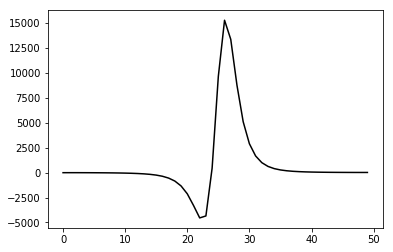

In [80]:
plt.figure()
plt.plot(np.arange(50), cc3, 'k-')
plt.show()

In [91]:
cc0 = np.zeros([50,50])
for i in range(50):
    for j in range(50):
        #cc0[i] = np.correlate(gz[:i], tf[:i], 'valid')
        cc0[i,j] = cc(gz[i], tf[j])

C:\Users\nelso\Anaconda2\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


In [92]:
print cc0.shape

(50L, 50L)


C:\Users\nelso\Anaconda2\lib\site-packages\numpy\ma\core.py:4185: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


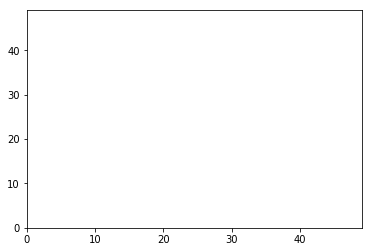

In [97]:
plt.figure()
plt.contourf(cc0)
plt.show()

In [3]:
# Definition for number of points and grid creation
n = 100
x = np.linspace(-2000., 2000., n)
y = np.copy(x)
z = -100.
# Creat the grid file
X, Y = np.meshgrid(x, y)

In [4]:
#Informations about the model - sphere
sphere = [0., 0., 600., 100., 2.]
# Inclination and declination (source and field)
[incs, decs] = [55., -48.]
field = [55., -48.]
pole = [90., 0]

In [5]:
# Calculating the total field anomaly
tf = gmc.sphere_tfa(X, Y, z, sphere, (incs, decs), field)
# Adding noise
tfa = addnoise(tf, 0.05, 0.01)

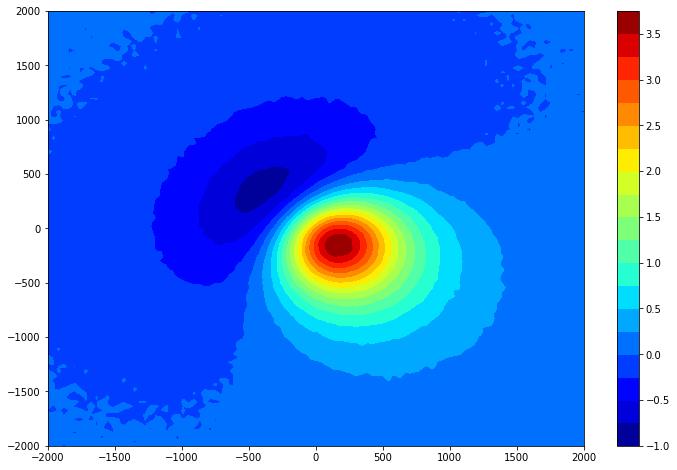

In [6]:
plt.figure(figsize=(12, 8))
plt.contourf(Y, X, tfa, 20, cmap = plt.cm.jet)
plt.colorbar()
plt.show()

In [7]:
# Calculate the reduce to pole
i, d = 7., -48
rtp = df.reduction(X, Y, tfa, field, (i, d), pole, pole)

datafiltering.py:147: RuntimeWarning: invalid value encountered in true_divide
  theta = z + ((x*u + y*v)/k)*1j


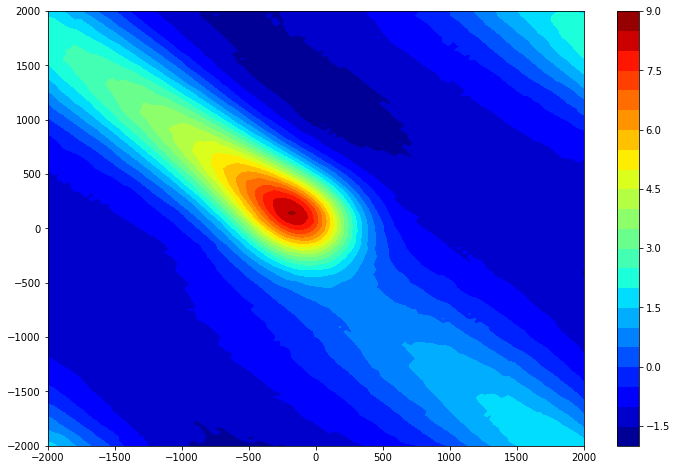

In [8]:
plt.figure(figsize=(12, 8))
plt.contourf(Y, X, rtp, 20, cmap = plt.cm.jet)
plt.colorbar()
plt.show()

In [9]:
# Computes the total gradient by using the calculated derivatives
tga = df.totalgrad(x, y, rtp)
# Vertical gradient
gv = df.zderiv(x, y, rtp, 1.)

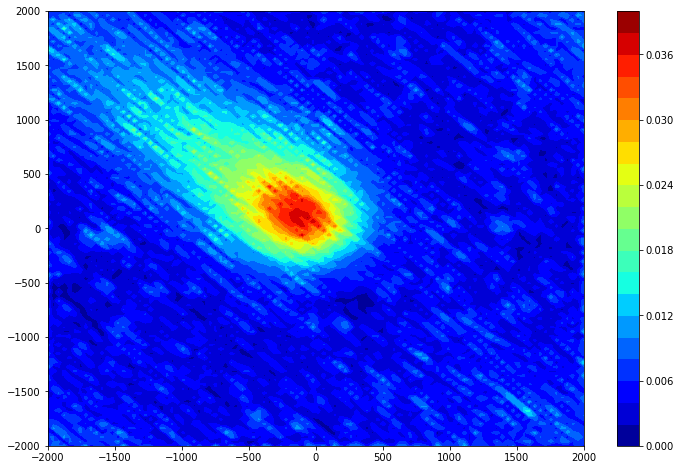

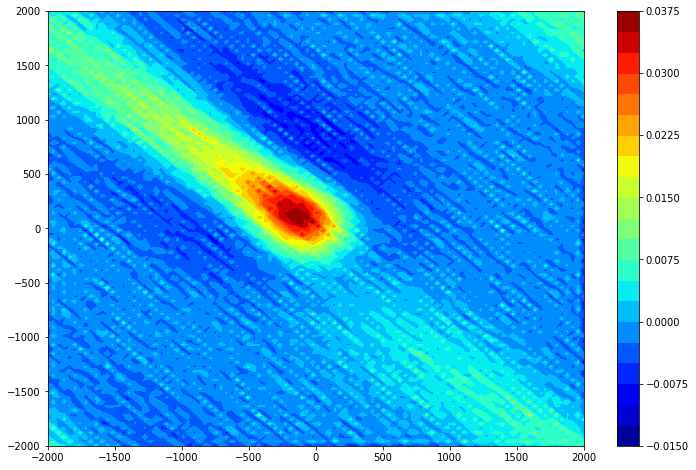

In [10]:
plt.figure(figsize=(12, 8))
plt.contourf(Y, X, tga, 20, cmap = plt.cm.jet)
plt.colorbar()
plt.show()

plt.figure(figsize=(12, 8))
plt.contourf(Y, X, gv, 20, cmap = plt.cm.jet)
plt.colorbar()
plt.show()

In [11]:
print cc(tga, gv)

0.599523356238


[[-0.00303597 -0.00077172  0.00170882 ...,  0.03754603  0.03759026
   0.04052309]
 [-0.00118148  0.00149743  0.00174069 ...,  0.04090286  0.04319333
   0.04151887]
 [ 0.00073487  0.00152519  0.00516409 ...,  0.04659198  0.04483055
   0.04642521]
 ..., 
 [ 0.04697861  0.04984223  0.05174953 ..., -0.00935523 -0.01260782
  -0.0131582 ]
 [ 0.04655689  0.04826449  0.05262757 ..., -0.01119826 -0.01097932
  -0.01417995]
 [ 0.04511022  0.04898465  0.05042418 ..., -0.00964055 -0.01262692
  -0.01391167]]


In [ ]:
res0 = np.correlate(tga.reshape(tga.size), gv.reshape(gv.size), 'valid')

In [ ]:
print np.corrcoef(tga, tga)
#print np.corrcoef(tga.reshape(tga.size), gv.reshape(gv.size)).min()
#(tga.reshape(tga.size), gv.reshape(gv.size))

In [ ]:
data1 = tga_pole.reshape(tga_pole.size)
data2 = derivz.reshape(derivz.size)

In [ ]:
res1 = np.correlate(data1, data2, 'same')
print res1.min(), res1.max()

res2 = np.correlate(data1, data2, 'full')
print res2.min(), res2.max()

In [ ]:
res0 = np.correlate(data1, data2, 'valid')
print res0.min(), res0.max()

In [ ]:
from scipy import signal

In [ ]:
corr = signal.correlate(data1, data2, mode='valid')/res0.size

In [ ]:
print corr.min(), corr.max()

In [ ]:
from scipy import signal
print signal.correlate(tga, gv, mode = 'same')

In [ ]:
# Printing the minimum and maximun values
print 'Using the first data vector:'
print 'Min =', v1.min(), '/', 'Max =', v1.max()
print 'Using the second data vector:'
print 'Min =', v2.min(), '/', 'Max =', v2.max()

In [ ]:
# Calculation of the means
m1 = np.mean(v1)
m2 = np.mean(v2)

In [ ]:
# Correlation using x and y as vectors
CC = np.zeros(N)
for n in range(N):
    CC[n] = (np.sum(v1[n]-m1)*(v2[n]-m2))
    CC[n] /= np.sqrt(np.sum(((v1[n]-m1)**2.)*((v2[n]-m2)**2.)))

In [ ]:
plt.figure(figsize=(12,8))
plt.title('Correlation between data vectors', fontsize = 18)
plt.plot(np.arange(N), CC, 'k-')
plt.xlabel('Number of points', fontsize = 14)
plt.ylabel('Cross correlation value', fontsize = 14)
plt.grid()
plt.show()

In [ ]:
# Computing the meshgrid
U, V = np.meshgrid(v1, v2)

In [ ]:
nu, mu = U.shape
nv, mv = V.shape
U = U.reshape(U.size)
V = V.reshape(V.size)

In [ ]:
# Simple correlation for data vectors v1 e v2
print 'Coeficient:'
print np.corrcoef(v1, v2)
print
print 'Valid method for correlation:', np.correlate(v1, v2, 'valid')
print
print 'Same method for correlation:'
print np.correlate(v1, v2, 'same')
print
print 'Full method for correlation:'
print np.correlate(v1, v2, 'full')

In [ ]:
# Simple correlation for data vectors v1 e v2
print 'Coeficient:'
print np.corrcoef(U,V)
print
print 'Valid method for correlation:', np.correlate(U, V, 'valid')
print
print 'Same method for correlation:'
print np.correlate(U, V, 'same')
print
print 'Full method for correlation:'
print np.correlate(U, V, 'full')

In [ ]:
# Computing the correlations - vectors
cc_valid = np.correlate(v1, v2, 'valid')
cc_same = np.correlate(v1, v2, 'same')
cc_full = np.correlate(v1, v2, 'full')
# Computing the correlations - grid
CC_valid = np.correlate(U, V, 'valid')
CC_same = np.correlate(U, V, 'same')
CC_full = np.correlate(U, V, 'full')

In [ ]:
print 'Minimum values:'
print cc_valid.min(), CC_valid.min()
print cc_same.min(), CC_same.min()
print cc_full.min(), CC_full.min()
print 'Maximum values:'
print cc_valid.max(), CC_valid.max()
print cc_same.max(), CC_same.max()
print cc_full.max(), CC_full.max()

In [ ]:
CC_same = CC_same.reshape(nu, mu)
plt.figure()
plt.contourf(U, V, CC_same, 20, cmap = plt.cm.jet)
plt.colorbar()
plt.show()

In [ ]:
# By using Scipy library
# https://docs.scipy.org/doc/scipy-0.16.1/reference/generated/scipy.signal.correlate.html
from scipy import signal